<a href="https://colab.research.google.com/github/Tanvir007/GAZIPUR-AIR-POLLUTION/blob/main/Gazipur_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import joblib
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [66]:
data = pd.read_csv('/content/drive/MyDrive/data science/Gazipurwithdatenew4.csv')
data.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO
0,2013,1,1,0,291.21,391.98,NaN,4.29,2.42
1,2013,1,1,1,237.25,303.03,NaN,4.20,2.11
2,2013,1,1,2,212.82,239.61,NaN,4.38,1.89
3,2013,1,1,3,148.47,169.46,NaN,4.35,1.73
4,2013,1,1,4,160.51,181.10,NaN,3.50,1.84


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    78888 non-null  int64  
 1   month   78888 non-null  int64  
 2   day     78888 non-null  int64  
 3   hour    78888 non-null  int64  
 4   PM2.5   53917 non-null  float64
 5   PM10    50947 non-null  float64
 6   SO2     36420 non-null  float64
 7   NO2     37396 non-null  float64
 8   CO      43773 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 5.4 MB


In [68]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : True

The total number of null values in each colum:


year         0
month        0
day          0
hour         0
PM2.5    24971
PM10     27941
SO2      42468
NO2      41492
CO       35115
dtype: int64

In [69]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)

In [70]:
# let's check the data again if there are any missing values
data.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
dtype: bool

In [71]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO
0,2013-01-01 00:00:00,2013,1,1,0,291.21,391.98,10.341965,4.29,2.42
1,2013-01-01 01:00:00,2013,1,1,1,237.25,303.03,10.341965,4.20,2.11
2,2013-01-01 02:00:00,2013,1,1,2,212.82,239.61,10.341965,4.38,1.89
3,2013-01-01 03:00:00,2013,1,1,3,148.47,169.46,10.341965,4.35,1.73
4,2013-01-01 04:00:00,2013,1,1,4,160.51,181.10,10.341965,3.50,1.84


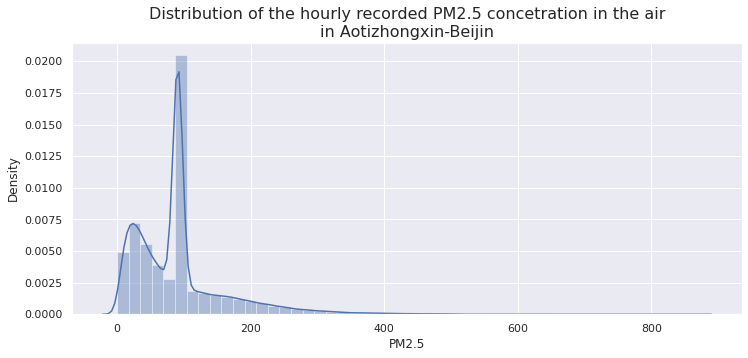

In [73]:
plt.figure(figsize=(12,5))
sns.distplot(data['PM2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Aotizhongxin-Beijin',
          fontsize=16)
plt.show()

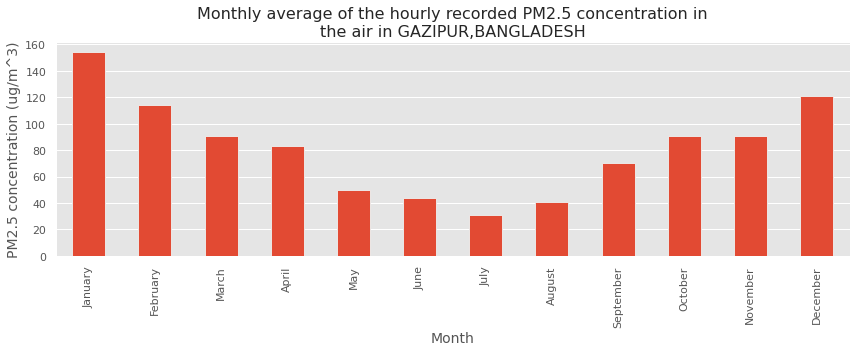

In [80]:
monthly_data = data[['month','PM2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in GAZIPUR,BANGLADESH',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()


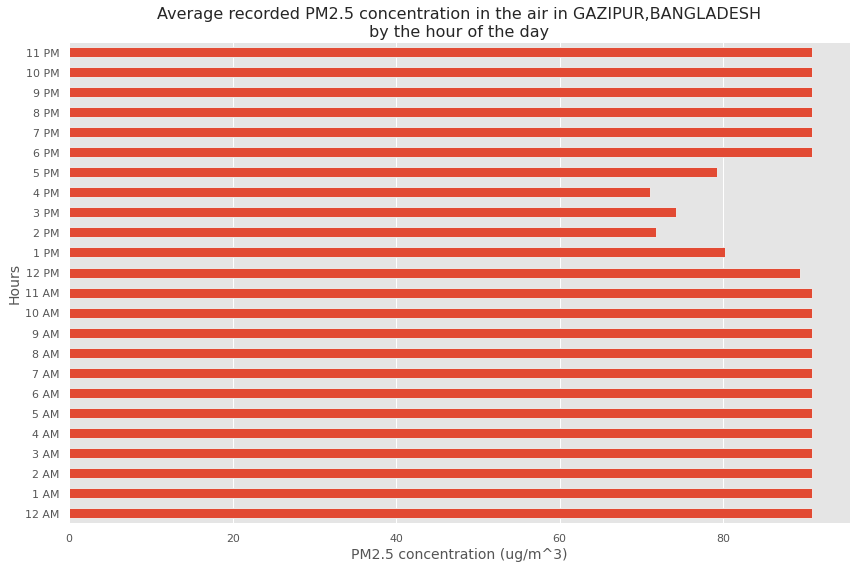

In [82]:
hourly_data = data[['hour','PM2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in GAZIPUR,BANGLADESH\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

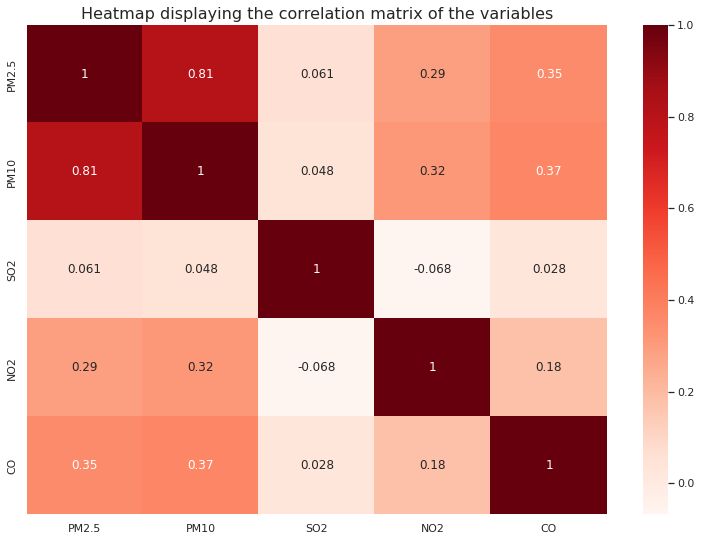

In [83]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

In [84]:
cols_to_drop = ['date','year','month','day','hour']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    7.447989
PM2.5    2.960080
PM10     3.038723
SO2      1.012221
NO2      1.130677
CO       1.177240
dtype: float64

In [86]:
newdata.columns = ['PM2_5','PM10','SO2','NO2','CO']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])

In [87]:
# fit the regression model
mul_reg = formula.ols(formula='PM2_5 ~ PM10 + SO2 + NO2 + CO',
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2_5   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.563e+04
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:58:36   Log-Likelihood:                -76821.
No. Observations:               78888   AIC:                         1.537e+05
Df Residuals:                   78883   BIC:                         1.537e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3157      0.006    532.743      0.000       3.303       3.328
PM10           0.0049   2.28e-05    213.102      0.000       0.005       0.005
SO2            0.0029      0.000     13.004      0.000       0.002       0.003
NO2            0.0031      0.000      9.466      0.000       0.002       0.004
CO             0.0438      0.003     15.060      0.000       0.038       0.049
==============================================================================
Omnibus:                    21911.244   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69274.660
Skew:                          -1.423   Prob(JB):                         0.00
Kurtosis:                       6.602   Cond. No.                         548.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM2_5',axis=1)
y = newdata['PM2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM10,SO2,NO2,CO
0,2.108901,-1.699709e-16,-0.672440,0.716802
1,1.316251,-1.699709e-16,-0.684513,0.351440
2,0.751103,-1.699709e-16,-0.660367,0.092150
3,0.125984,-1.699709e-16,-0.664392,-0.096424
4,0.229710,-1.699709e-16,-0.778412,0.033221


In [89]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [90]:
# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.44381105132462606

Score on test data: 0.43482482178773685


In [91]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 0.4119835692058011

Overall model accuracy: 0.43482482178773685


In [92]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM2.5',axis=1)
y = ensemble_data['PM2.5']

In [93]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

In [94]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [95]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.7036507575700649

Score on test data: 0.6948330291160192

Root Mean Squared Error: 38.12651418626868

Overall model accuracy: 0.6948330291160192


In [96]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [97]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.7189952450906464

Score on test data: 0.7021914665375786

Best parameters found:


{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 9,
 'min_samples_split': 7}

Root Mean Squared Error: 37.664040326116606

Overall model accuracy: 0.7021914665375786


In [98]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7)

In [99]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.7319830617896503

Score on test data: 0.7140437309903311

Root Mean Squared Error: 36.90694929587573

Overall model accuracy: 0.7140437309903311


In [100]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [102]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.729609402899625

Score on test data: 0.7161889458680437

Best parameters found:


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 7}

Root Mean Squared Error: 36.768252592054715

Overall model accuracy: 0.7161889458680437


In [103]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [104]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.7897358471915266

Score on test data: 0.7326646787473204

Root Mean Squared Error: 35.68506635805069

Overall model accuracy: 0.7326646787473204


In [105]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [106]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.7597362506930067

Score on test data: 0.7170265992223281

Best parameters found:


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'learning_rate': 0.4}

Root Mean Squared Error: 36.71395271770598

Overall model accuracy: 0.7170265992223281


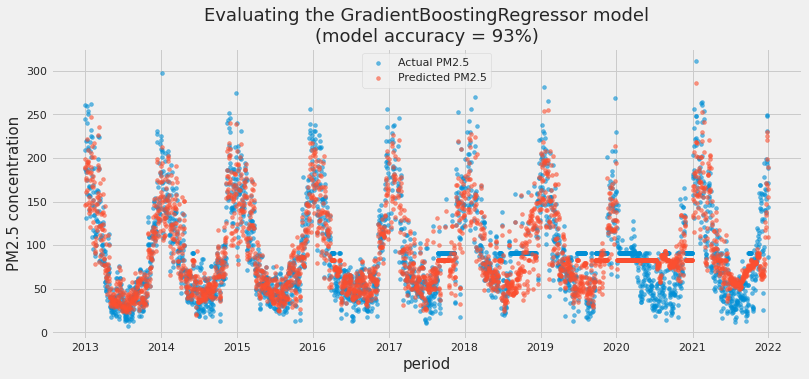

In [107]:
# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5 
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 93%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

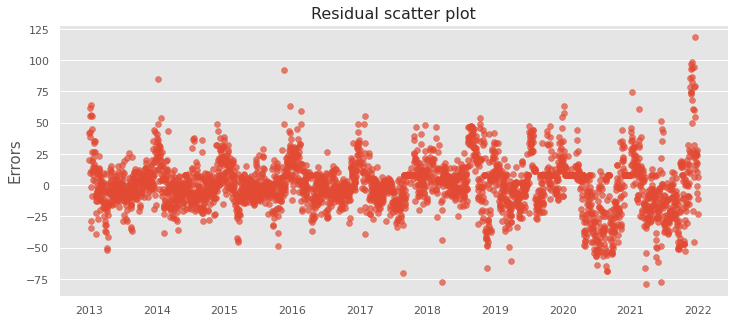

In [108]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM2.5'] - compare_data['Predicted PM2.5']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=16)
    plt.ylabel('Errors',fontsize=15)
    plt.grid(axis='x')
    plt.show()

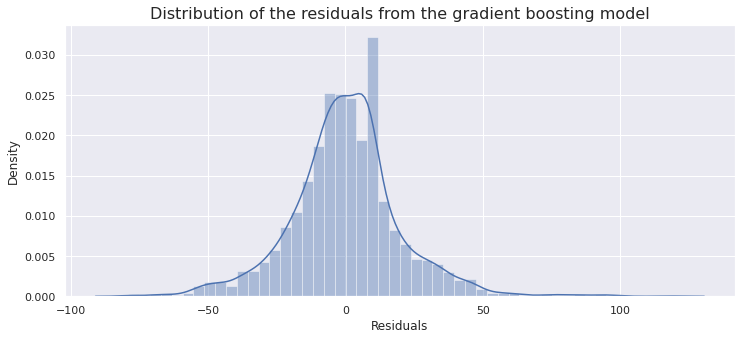

In [109]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(12,5))
sns.distplot(compare_data.Residuals,bins=50)
plt.title('Distribution of the residuals from the gradient boosting model',
         fontsize=16)
plt.show()

In [111]:
import joblib

In [112]:
# save the model to my desktop
joblib.dump(gboost_search,'.\\F:\Environmental Engineering\Air Treatment\Term Paper\Term data\model\\pm25_model.pkl')

['.\\F:\\Environmental Engineering\\Air Treatment\\Term Paper\\Term data\\model\\pm25_model.pkl']

In [113]:
# loading the model
regression_model = joblib.load('.\\F:\Environmental Engineering\Air Treatment\Term Paper\Term data\model\\pm25_model.pkl')